# NLP - Exploration Exercise

In [1]:
from functools import partial
from importlib import reload

import pandas as pd

import acquire
import prepare
import adalib

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

import nltk

In [2]:
acquire = reload(acquire)
prepare = reload(prepare)

## Spam Data

In [3]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

In [4]:
df_orig = pd.read_csv("spam_clean.csv")

In [5]:
df_orig.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
remove_stopwords_spam = partial(prepare.remove_stopwords, include=ADDITIONAL_STOPWORDS)

text_clean = df_orig.text.apply(adalib.pipe, args=(prepare.basic_clean,
                                                   lambda s: s.replace("'", ""),
                                                 prepare.tokenize,
                                                 remove_stopwords_spam,
                                                 prepare.lemmatize))

In [7]:
df = pd.concat([df_orig.label, text_clean], axis=1)

In [8]:
df.head()

,label,text
0,ham,go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif oni
2,spam,free entry wkly comp win fa cup final tkts 21s...
3,ham,dun say early hor c already say
4,ham,nah dont think go usf life around thoug


In [9]:
df.groupby("label").describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham    4825   4484                                sorry ill call late   30
spam    747    646  please call customer service representative fr...    4

In [10]:
ham_words = ' '.join(df[df.label == 'ham'].text)
spam_words = ' '.join(df[df.label == 'spam'].text)
all_words = ' '.join(df.text)

In [11]:
ham_words[:100]

'go jurong point crazy available bugis n great world la e buffet cine got amore wat ok lar joking wif'

In [12]:
ham_freq = pd.Series(ham_words.split()).value_counts()
spam_freq = pd.Series(spam_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

In [13]:
word_counts = pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)\
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)\
                .fillna(0)\
                .apply(lambda s: s.astype(int))

word_counts.head()

,all,ham,spam
0,3,0,3
008704050406,2,0,2
0089my,1,0,1
0121,1,0,1
01223585236,1,0,1


**Most frequently occuring words**

In [14]:
word_counts.sort_values(by='all', ascending=False).head(10)

,all,ham,spam
call,588,234,354
im,463,450,13
get,397,314,83
ur,384,240,144
go,307,276,31
4,289,170,119
dont,279,257,22
free,269,54,215
ok,265,260,5
know,261,235,26


**Words that are unique to ham and spam messages**

In [15]:
pd.concat([word_counts[word_counts.spam == 0].sort_values(by='ham', ascending=False).head(6),
           word_counts[word_counts.ham == 0].sort_values(by='spam', ascending=False).head(6)])

,all,ham,spam
lor,160,160,0
da,143,143,0
say,118,118,0
thats,94,94,0
later,91,91,0
ask,86,86,0
claim,115,0,115
prize,94,0,94
tone,73,0,73
guaranteed,50,0,50


Text(0.5, 1.0, 'Proportion of Spam vs Ham for the 20 most common words')

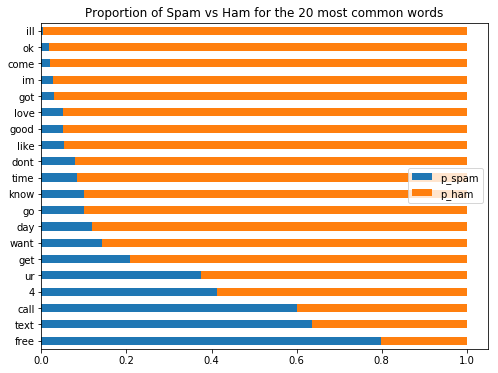

In [16]:
# figure out the percentage of spam vs ham
(word_counts
 .assign(p_spam=word_counts.spam / word_counts['all'],
         p_ham=word_counts.ham / word_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True, figsize=(8, 6)))

plt.title('Proportion of Spam vs Ham for the 20 most common words')

In [17]:
(word_counts
 [(word_counts.spam > 10) & (word_counts.ham > 10)]
 .assign(ratio=lambda df: df.spam / df.ham)
 .sort_values(by='ratio')
 .pipe(lambda df: pd.concat([df.head(), df.tail()])))

,all,ham,spam,ratio
im,463,450,13,0.028889
good,232,220,12,0.054545
like,242,229,13,0.056769
need,182,171,11,0.064327
dont,279,257,22,0.085603
free,269,54,215,3.981481
contact,70,14,56,4.000000
win,76,15,61,4.066667
mobile,149,14,135,9.642857
txt,164,12,152,12.666667


## Word cloud

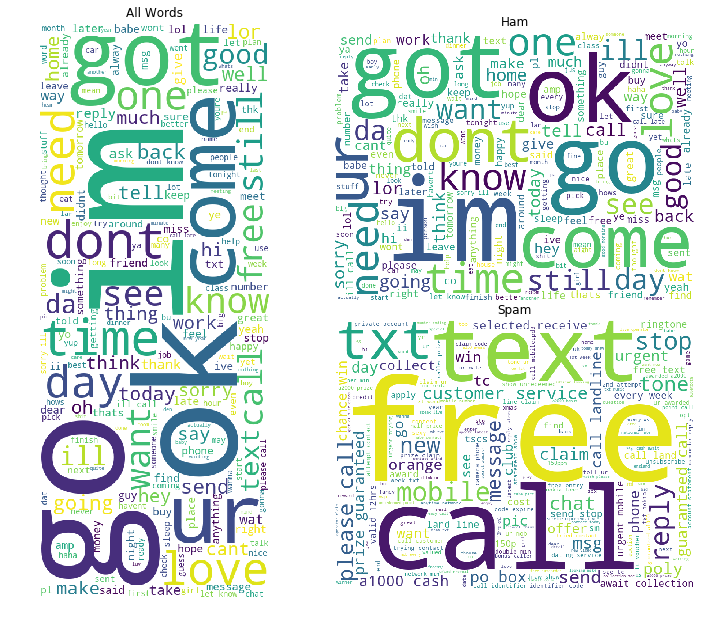

In [18]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(all_words)
ham_cloud = WordCloud(background_color='white', height=600, width=800).generate(ham_words)
spam_cloud = WordCloud(background_color='white', height=600, width=800).generate(spam_words)

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(ham_cloud)
axs[2].imshow(spam_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Ham')
axs[2].set_title('Spam')

for ax in axs: ax.axis('off')

**Exploring ham bigrams**

In [19]:
ham_bigrams = pd.Series(nltk.ngrams(ham_words.split(), 2)).value_counts()

ham_bigrams.head()

(ill, call)        48
(let, know)        42
(sorry, ill)       39
(call, late)       33
(good, morning)    31
dtype: int64

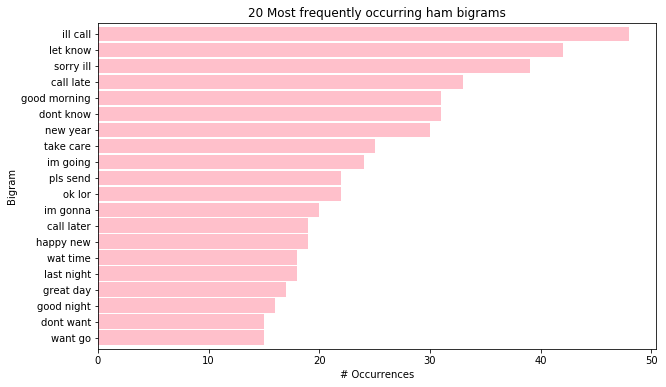

In [20]:
ham_bigrams.sort_values().tail(20).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occurring ham bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurrences')

# make the labels pretty
ticks, _ = plt.yticks()
labels = ham_bigrams.sort_values().tail(20).reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

**Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?**

The spam diagrams suggest a focus on commerce and getting the recipient to do something. The ham bigrams are focused on communication and what action the sender is taking.

In [21]:
spam_bigrams = pd.Series(nltk.ngrams(spam_words.split(), 2)).value_counts()

spam_bigrams.head()

(please, call)         44
(customer, service)    27
(po, box)              24
(guaranteed, call)     23
(a1000, cash)          23
dtype: int64

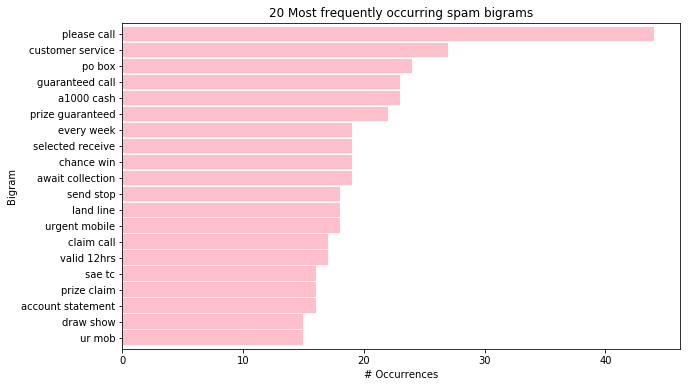

In [22]:
spam_bigrams.sort_values().tail(20).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occurring spam bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurrences')

# make the labels pretty
ticks, _ = plt.yticks()
labels = spam_bigrams.sort_values().tail(20).reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

(-0.5, 799.5, 399.5, -0.5)

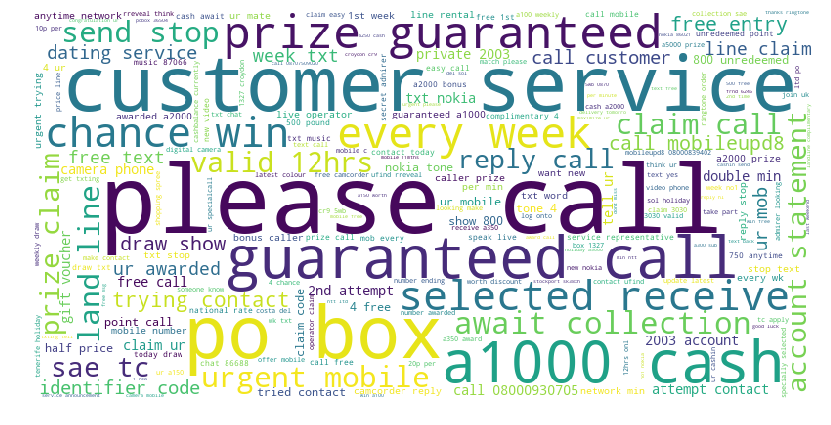

In [23]:
data = {k[0] + ' ' + k[1]: v for k, v in spam_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(14, 10))
plt.imshow(img)
plt.axis('off')

**Is there any overlap in the bigrams for the spam data and the ham data?**

In [24]:
overlap = pd.concat([ham_bigrams, spam_bigrams], join="inner", axis=1).rename(columns={0: "ham", 1: "spam"})

most likely to be in ham

In [25]:
overlap.sort_values(by="ham", ascending=False).head()

,ham,spam
"(dont, know)",31,6
"(new, year)",30,2
"(im, home)",13,1
"(last, week)",11,1
"(first, time)",10,1


most likely to be in spam

In [26]:
overlap.sort_values(by="spam", ascending=False).head()

,ham,spam
"(please, call)",3,44
"(customer, service)",2,27
"(po, box)",1,24
"(every, week)",2,19
"(send, stop)",1,18


In [27]:
overlap[abs(overlap.ham - overlap.spam) < 4].sort_values(by="ham", ascending=False).head()

,ham,spam
"(missed, call)",5,2
"(give, u)",5,2
"(pls, call)",4,2
"(text, im)",4,2
"(got, new)",4,1


**Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.**

### Ham

In [28]:
ham_trigrams = pd.Series(nltk.ngrams(ham_words.split(), 3)).value_counts()

ham_trigrams.head()

(sorry, ill, call)     38
(ill, call, late)      33
(happy, new, year)     19
(right, pls, send)     12
(cant, pick, phone)    12
dtype: int64

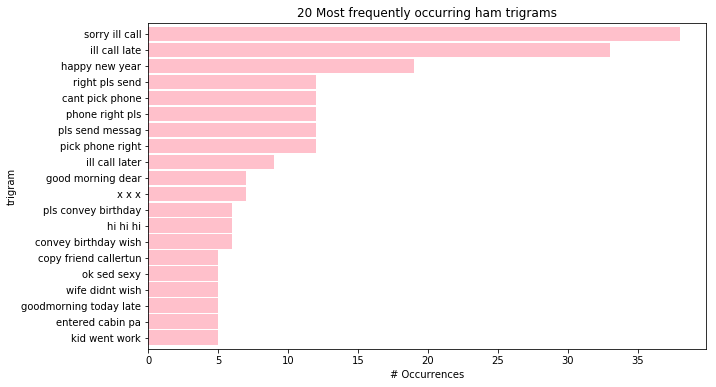

In [29]:
ham_trigrams.sort_values().tail(20).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occurring ham trigrams')
plt.ylabel('trigram')
plt.xlabel('# Occurrences')

# make the labels pretty
ticks, _ = plt.yticks()
labels = ham_trigrams.sort_values().tail(20).reset_index()['index'].apply(lambda t: " ".join(t))
_ = plt.yticks(ticks, labels)

(-0.5, 799.5, 399.5, -0.5)

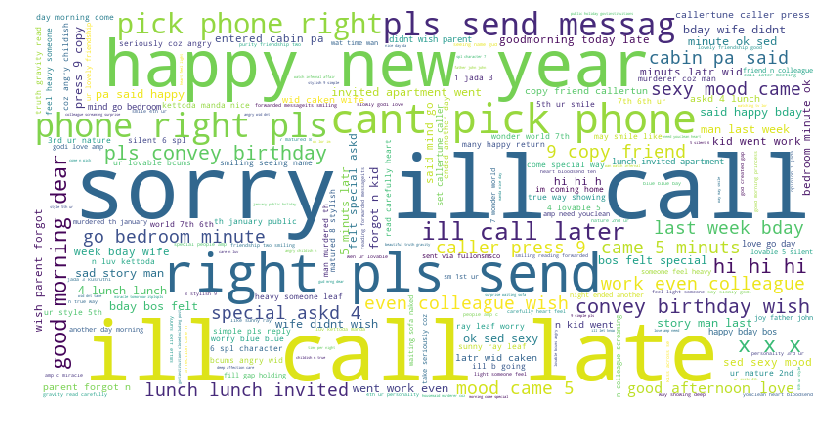

In [30]:
data = {" ".join(k): v for k, v in ham_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(14, 10))
plt.imshow(img)
plt.axis('off')

### Spam

In [31]:
spam_trigrams = pd.Series(nltk.ngrams(spam_words.split(), 3)).value_counts()

spam_trigrams.head()

(prize, guaranteed, call)     21
(call, customer, service)     15
(land, line, claim)           14
(2003, account, statement)    13
(private, 2003, account)      13
dtype: int64

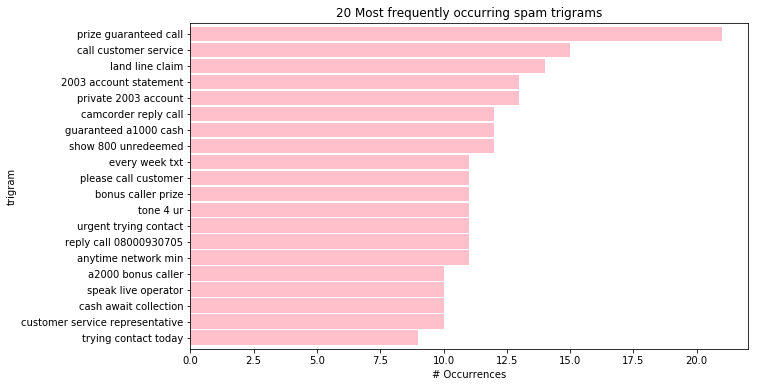

In [32]:
spam_trigrams.sort_values().tail(20).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occurring spam trigrams')
plt.ylabel('trigram')
plt.xlabel('# Occurrences')

# make the labels pretty
ticks, _ = plt.yticks()
labels = spam_trigrams.sort_values().tail(20).reset_index()['index'].apply(lambda t: " ".join(t))
_ = plt.yticks(ticks, labels)

(-0.5, 799.5, 399.5, -0.5)

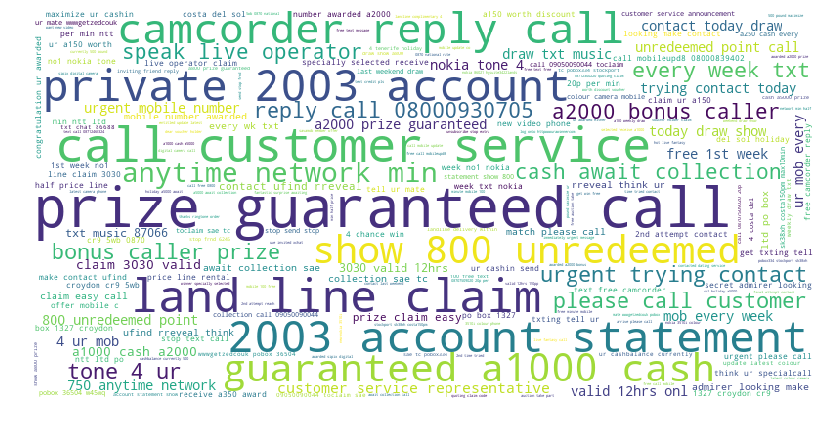

In [33]:
data = {" ".join(k): v for k, v in spam_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(14, 10))
plt.imshow(img)
plt.axis('off')

## 2. Explore the blog articles using the techniques discussed in the exploration lesson.

In [34]:
articles_raw = acquire.get_blog_articles()

In [35]:
articles = prepare.prepare_article_data(articles_raw)

In [36]:
df = pd.DataFrame(articles)

In [37]:
df.head()

,author,clean,date,lemmatized,original,stemmed,title
0,Joyce Ling,months starting codeup redwood cohort sitting ...,2019-04-26,month starting codeup redwood cohort sitting f...,\nJust a few months before starting at Codeup ...,month start codeup redwood cohort sit footbal ...,5 Common Excuses Keeping You From Breaking Int...
1,Joyce Ling,moving san antonio slightly apprehensive knowi...,2019-04-01,moving san antonio slightly apprehensive knowi...,"\nBefore moving to San Antonio, I was slightly...",move san antonio slightli apprehens know littl...,Why San Antonio Has More Than Tacos To Offer
2,Joyce Ling,come home work tired bone groaning realize for...,2019-03-11,come home work tired bone groaning realize for...,"\nYou come home from work, tired to the bone a...",come home work tire bone groan realiz forgot p...,Everyday Encounters with Data Science
3,Yumi Jeon,marcella munter looked codeup 2 years finally ...,2018-11-14,marcella munter looked codeup 2 year finally m...,\n \n\n\nBy Marcella Munter\nI looked at Codeu...,marcella munter look codeup 2 year final made ...,Finding the Perfect Coding Bootcamp Fit for Me
4,Yumi Jeon,photo jon garcia codeup welcomed wrangell coho...,2018-11-12,photo jon garcia codeup welcomed wrangell coho...,\nPhoto by Jon Garcia\nCodeup welcomed the Wra...,photo jon garcia codeup welcom wrangel cohort ...,Codeup Student Check In: Month 3


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 7 columns):
author        63 non-null object
clean         63 non-null object
date          63 non-null object
lemmatized    63 non-null object
original      63 non-null object
stemmed       63 non-null object
title         63 non-null object
dtypes: object(7)
memory usage: 3.5+ KB


In [39]:
df.author.value_counts()

Yumi Jeon     60
Joyce Ling     3
Name: author, dtype: int64

In [40]:
blog_words = " ".join(df.lemmatized)

In [41]:
print(len(blog_words))
print(blog_words[:100])

147716
month starting codeup redwood cohort sitting football stadium university colorado boulder pondering 


**Most frequently occuring words**

In [42]:
blog_freq = pd.Series(blog_words.split()).value_counts()
blog_freq.head(10)

codeup       284
student      161
job          128
developer    127
tech         120
new          109
one          105
like         104
time         103
skill        102
dtype: int64

**Number of words**

In [43]:
len(blog_freq)

4424

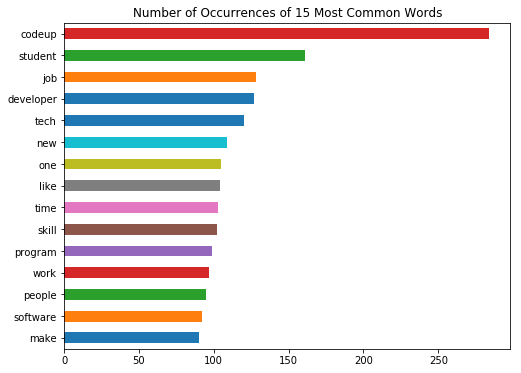

In [44]:
blog_freq.sort_values().tail(15).plot.barh(figsize=(8, 6))
plt.title("Number of Occurrences of 15 Most Common Words")
plt.show()

In [45]:
df_blog = blog_freq.reset_index().rename(columns={"index": "word", 0: "occurs"}).assign(ratio=blog_freq.values / len(blog_freq))
df_blog.head(10)

,word,occurs,ratio
0,codeup,284,0.064195
1,student,161,0.036392
2,job,128,0.028933
3,developer,127,0.028707
4,tech,120,0.027125
5,new,109,0.024638
6,one,105,0.023734
7,like,104,0.023508
8,time,103,0.023282
9,skill,102,0.023056


## Word cloud

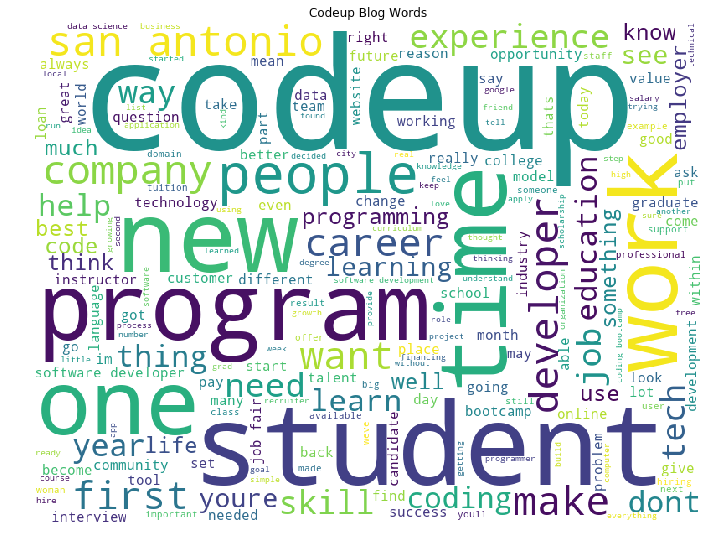

In [46]:
blog_cloud = WordCloud(background_color="white", width=800, height=600).generate(blog_words)
plt.figure(figsize=(12, 10))
plt.title("Codeup Blog Words")
plt.axis("off")
plt.imshow(blog_cloud)
plt.show()

### Exploring blog bigrams

In [47]:
blog_bigrams = pd.Series(nltk.ngrams(blog_words.split(), 2)).value_counts()

blog_bigrams.head()

(san, antonio)             76
(software, developer)      44
(job, fair)                26
(software, development)    23
(data, science)            21
dtype: int64

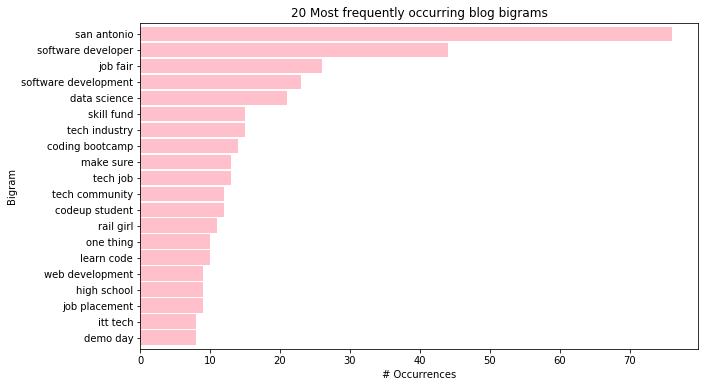

In [48]:
blog_bigrams.sort_values().tail(20).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occurring blog bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurrences')

# make the labels pretty
ticks, _ = plt.yticks()
labels = blog_bigrams.sort_values().tail(20).reset_index()['index'].apply(lambda t: " ".join(t))
_ = plt.yticks(ticks, labels)

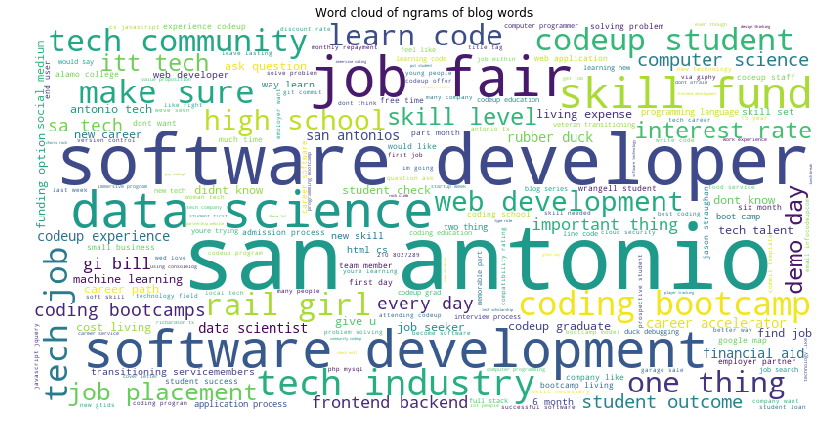

In [49]:
data = {" ".join(k): v for k, v in blog_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(14, 10))
plt.imshow(img)
plt.axis('off')
plt.title("Word cloud of ngrams of blog words")
plt.show()

### Trigrams

In [50]:
blog_trigrams = pd.Series(nltk.ngrams(blog_words.split(), 3)).value_counts()

blog_trigrams.head()

(tech, job, fair)                           12
(san, antonio, tech)                         6
(codeup, student, check)                     6
(veteran, transitioning, servicemembers)     5
(bootcamp, living, expense)                  5
dtype: int64

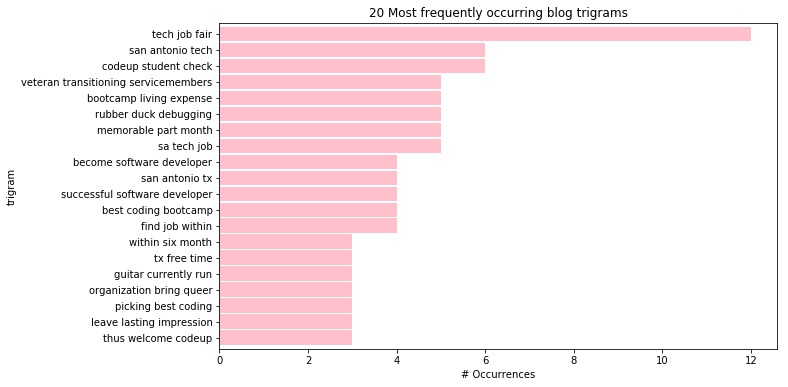

In [51]:
blog_trigrams.sort_values().tail(20).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occurring blog trigrams')
plt.ylabel('trigram')
plt.xlabel('# Occurrences')

# make the labels pretty
ticks, _ = plt.yticks()
labels = blog_trigrams.sort_values().tail(20).reset_index()['index'].apply(lambda t: " ".join(t))
_ = plt.yticks(ticks, labels)

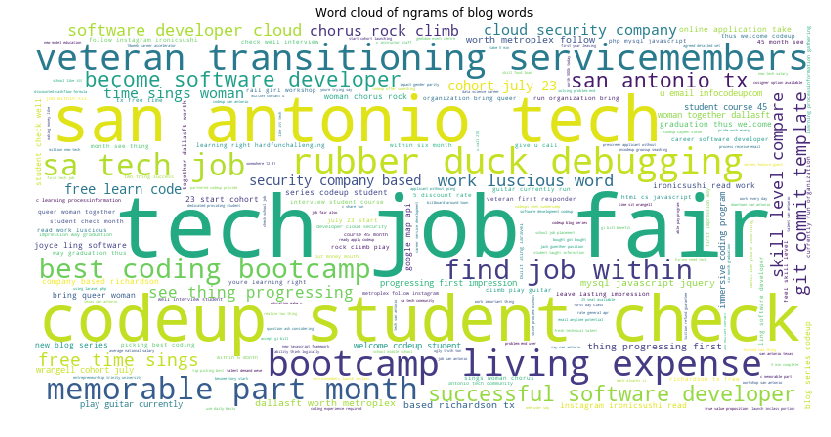

In [52]:
data = {" ".join(k): v for k, v in blog_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(14, 10))
plt.imshow(img)
plt.axis('off')
plt.title("Word cloud of ngrams of blog words")
plt.show()

## News Article Data

**Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.**

In [53]:
articles_raw = acquire.get_news_articles()

In [54]:
articles = prepare.prepare_article_data(articles_raw)

In [55]:
df = pd.DataFrame(articles)

In [56]:
df.head()

,category,clean,lemmatized,original,stemmed,title
0,business,ratan tata chairman emeritus tata sons investe...,ratan tata chairman emeritus tata son invested...,"Ratan Tata, the Chairman Emeritus of Tata Sons...",ratan tata chairman emeritu tata son invest un...,Ratan Tata invests in Ola's newly-formed compa...
1,business,reliance group accused rahul gandhi engaging c...,reliance group accused rahul gandhi engaging c...,The Reliance Group has accused Rahul Gandhi of...,relianc group accus rahul gandhi engag calumni...,Malicious lies: Anil Ambani's Reliance on Rahu...
2,business,rahul gandhi called anil ambani crony capitali...,rahul gandhi called anil ambani crony capitali...,After Rahul Gandhi called Anil Ambani a crony ...,rahul gandhi call anil ambani croni capitalist...,Got ₹1L cr of contracts during UPA rule: Relia...
3,business,asked congress fund nyay scheme elected expm m...,asked congress fund nyay scheme elected expm m...,On being asked how Congress will fund its NYAY...,ask congress fund nyay scheme elect expm manmo...,No new taxes on the middle class to finance NY...
4,business,supreme court monday stayed 500crore fine nati...,supreme court monday stayed 500crore fine nati...,The Supreme Court on Monday stayed the ₹500-cr...,suprem court monday stay 500crore fine nation ...,SC stays NGT's ₹500 crore fine on Volkswagen f...


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
category      100 non-null object
clean         100 non-null object
lemmatized    100 non-null object
original      100 non-null object
stemmed       100 non-null object
title         100 non-null object
dtypes: object(6)
memory usage: 4.8+ KB


In [58]:
df.category.value_counts()

entertainment    25
technology       25
sports           25
business         25
Name: category, dtype: int64

In [59]:
news_words = " ".join(df.lemmatized)

In [60]:
print(len(news_words))
print(news_words[:100])

26859
ratan tata chairman emeritus tata son invested undisclosed amount ola newlyformed company ola electr


**Most frequently occuring words**

In [61]:
news_freq = pd.Series(news_words.split()).value_counts()
news_freq.head(10)

said          68
crore         56
company       36
quarter       32
india         32
monday        24
year          24
government    24
buffett       24
market        24
dtype: int64

**Number of words**

In [62]:
len(news_freq)

645

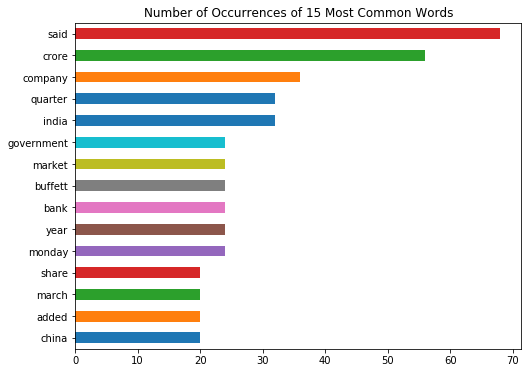

In [63]:
news_freq.sort_values().tail(15).plot.barh(figsize=(8, 6))
plt.title("Number of Occurrences of 15 Most Common Words")
plt.show()

In [64]:
df_news = news_freq.reset_index().rename(columns={"index": "word", 0: "occurs"}).assign(ratio=news_freq.values / len(news_freq))
df_news.head(10)

,word,occurs,ratio
0,said,68,0.105426
1,crore,56,0.086822
2,company,36,0.055814
3,quarter,32,0.049612
4,india,32,0.049612
5,monday,24,0.037209
6,year,24,0.037209
7,government,24,0.037209
8,buffett,24,0.037209
9,market,24,0.037209


## Word cloud

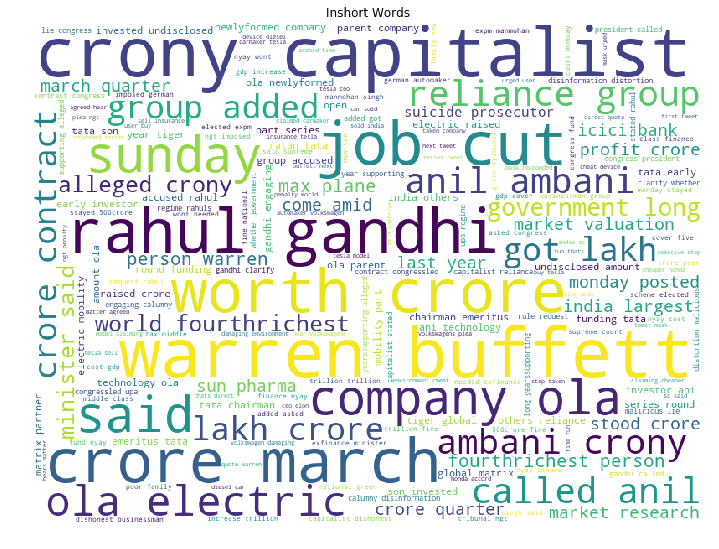

In [65]:
news_cloud = WordCloud(background_color="white", width=800, height=600).generate(news_words)
plt.figure(figsize=(12, 10))
plt.title("Inshort Words")
plt.axis("off")
plt.imshow(news_cloud)
plt.show()

**Exploring blog bigrams**

In [66]:
news_bigrams = pd.Series(nltk.ngrams(news_words.split(), 2)).value_counts()

news_bigrams.head()

(warren, buffett)      16
(crony, capitalist)    16
(job, cut)             12
(crore, march)         12
(rahul, gandhi)        12
dtype: int64

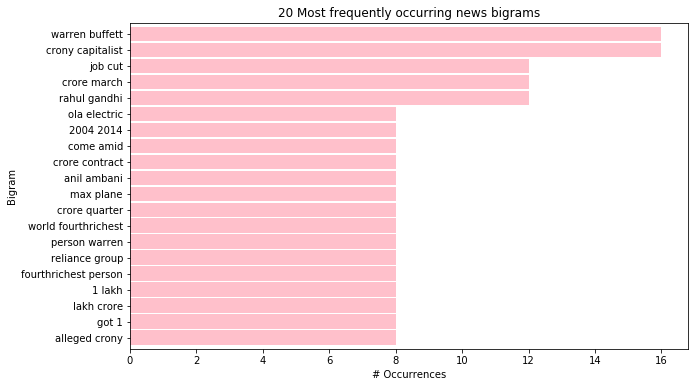

In [67]:
news_bigrams.sort_values().tail(20).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occurring news bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurrences')

# make the labels pretty
ticks, _ = plt.yticks()
labels = news_bigrams.sort_values().tail(20).reset_index()['index'].apply(lambda t: " ".join(t))
_ = plt.yticks(ticks, labels)

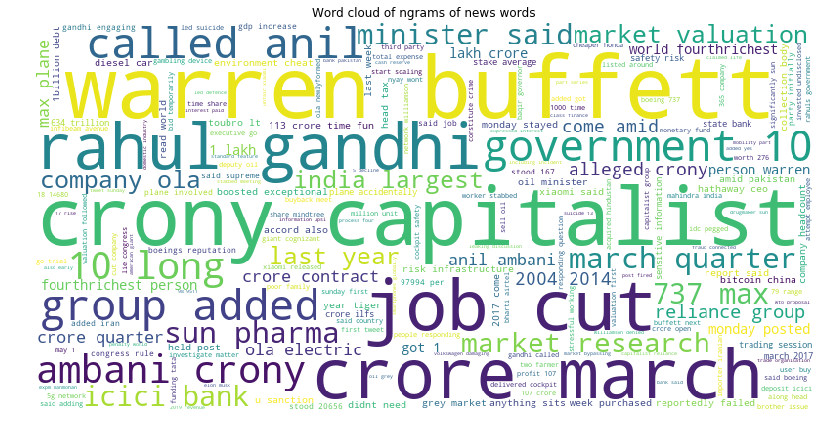

In [68]:
data = {" ".join(k): v for k, v in news_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(14, 10))
plt.imshow(img)
plt.axis('off')
plt.title("Word cloud of ngrams of news words")
plt.show()

### Trigrams

In [69]:
news_trigrams = pd.Series(nltk.ngrams(news_words.split(), 3)).value_counts()

news_trigrams.head()

(ambani, crony, capitalist)    8
(lakh, crore, contract)        8
(1, lakh, crore)               8
(person, warren, buffett)      8
(called, anil, ambani)         8
dtype: int64

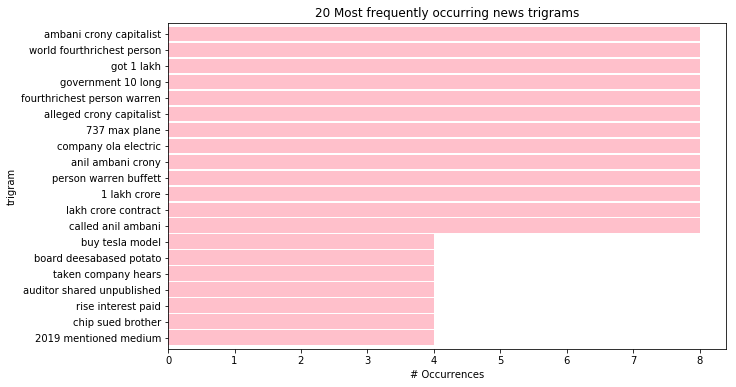

In [70]:
news_trigrams.sort_values().tail(20).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occurring news trigrams')
plt.ylabel('trigram')
plt.xlabel('# Occurrences')

# make the labels pretty
ticks, _ = plt.yticks()
labels = news_trigrams.sort_values().tail(20).reset_index()['index'].apply(lambda t: " ".join(t))
_ = plt.yticks(ticks, labels)

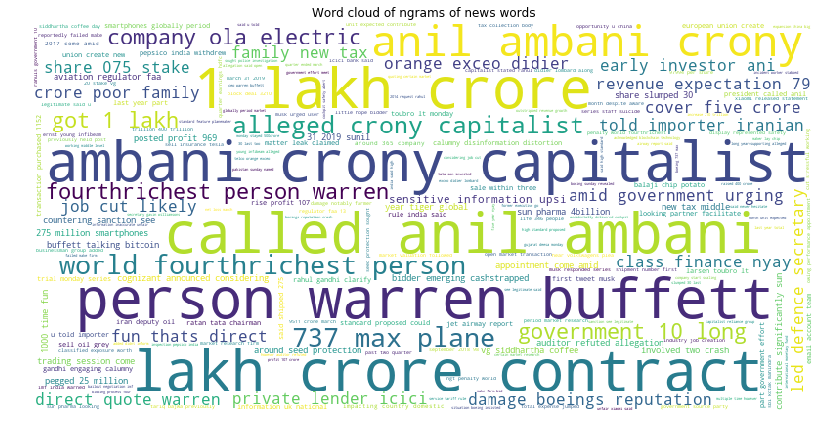

In [71]:
data = {" ".join(k): v for k, v in news_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(14, 10))
plt.imshow(img)
plt.axis('off')
plt.title("Word cloud of ngrams of news words")
plt.show()